# **LIAR Dataset -**

id: Contains id - unique identifier.

label: Contains the labels true, false, half-true, pants-fire, barely-true, mostly-true.

statement: Statements made - your input corpus.

subject: Contains topics of discussion.

speaker: Contains the details of the speaker such as the name of the speaker.

job_title: Contains the job title of the speaker.

state_info: Contains the name of the state.

party_affiliation: Contains details on party affiliation of speaker

barely_true_counts: Contains the count for a barely true statements of speaker in past.

false_counts: Contains the count for false statements of speaker in past.

half_true_counts: Contains the count for half-true statements of speaker in past.

mostly_true_counts: Contains the count for mostly true statements of speaker in past.

pants_onfire_counts: Contains the count for pants on fire counts - rubbish statements of speaker in past.

context: Column that contains the context - where was the statement made.

In [3]:
# Install required packages
!pip install deeplake
!pip install "deeplake<4"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.7/618.7 kB 8.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:

In [6]:
# Import necessary libraries
import pandas as pd
import deeplake
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
import torch
from sklearn.ensemble import RandomForestClassifier

In [7]:
# Load datasets from Deeplake
ds_train = deeplake.load('hub://activeloop/liar-train')
ds_test = deeplake.load('hub://activeloop/liar-test')
ds_val = deeplake.load('hub://activeloop/liar-val')

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/liar-train



\

hub://activeloop/liar-train loaded successfully.



Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/liar-test



/

hub://activeloop/liar-test loaded successfully.



Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/liar-val



\

hub://activeloop/liar-val loaded successfully.



In [8]:
# Define label mapping
label_map = {
    0: "Pants on Fire",
    1: "False",
    2: "Barely True",
    3: "Half True",
    4: "Mostly True",
    5: "True"
}

# Preview first 5 statements and labels from the training dataset
for i in range(5):
    statement = ds_train[i]['statement'].numpy()[0]
    label = ds_train[i]['label'].numpy()[0]
    print(f"Statement {i+1}: {statement}")
    print(f"Label {i+1}: {label_map[label]}")
    print("-" * 80)

Statement 1: Says the Annies List political group supports third-trimester abortions on demand.
Label 1: Pants on Fire
--------------------------------------------------------------------------------
Statement 2: When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.
Label 2: False
--------------------------------------------------------------------------------
Statement 3: Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."
Label 3: Barely True
--------------------------------------------------------------------------------
Statement 4: Health care reform legislation is likely to mandate free sex change surgeries.
Label 4: Pants on Fire
--------------------------------------------------------------------------------
Statement 5: The economic turnaround started at the end of my term.
Label 5: False
-------------------------------------------------

In [9]:
from collections import Counter

# Extract labels from the dataset
labels = [ds_train[i]['label'].numpy()[0] for i in range(len(ds_train))]

# Count the occurrences of each label
label_counts = Counter(labels)

# Print the counts for each class
for label, count in label_counts.items():
    print(f"{label_map[label]}: {count}")

/usr/local/lib/python3.10/dist-packages/deeplake/core/dataset/dataset.py:635: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


Pants on Fire: 1995
False: 2114
Barely True: 1962
Half True: 1676
Mostly True: 1654
True: 839


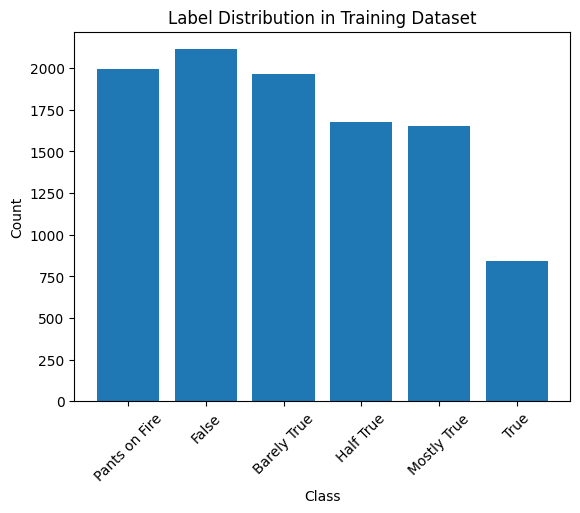

In [10]:
# Plot the distribution (optional, for better visualization)
import matplotlib.pyplot as plt

plt.bar([label_map[label] for label in label_counts.keys()], label_counts.values())
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Label Distribution in Training Dataset")
plt.xticks(rotation=45)
plt.show()

In [12]:
# from collections import Counter

# # Extract labels from the training dataset
# labels = [ds_train[i]['label'].numpy()[0] for i in range(len(ds_train))]

# # Count the occurrences of each label
# label_counts = Counter(labels)

# Find majority and minority class counts
majority_count = max(label_counts.values())
minority_count = min(label_counts.values())

# Calculate the ratio
imbalance_ratio = majority_count / minority_count

# # Print the results
# print("Class counts:")
# for label, count in label_counts.items():
#     print(f"{label_map[label]}: {count}")

print("\nMajority class count:", majority_count)
print("Minority class count:", minority_count)
print(f"Imbalance ratio (majority:minority): {imbalance_ratio:.2f}")


Majority class count: 2114
Minority class count: 839
Imbalance ratio (majority:minority): 2.52


In [13]:
import deeplake
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
import pandas as pd
import torch
from sklearn.ensemble import RandomForestClassifier

In [14]:
# Addressing class imbalance using oversampling (reuse from earlier code)
data = {
    "statement": [ds_train[i]['statement'].numpy()[0] for i in range(len(ds_train))],
    "label": [ds_train[i]['label'].numpy()[0] for i in range(len(ds_train))]
}
df_train = pd.DataFrame(data)

In [15]:
# Separate majority and minority classes
df_majority = df_train[df_train['label'] == df_train['label'].mode()[0]]  # Majority class
dfs_minority = [df_train[df_train['label'] == label] for label in df_train['label'].unique() if label != df_train['label'].mode()[0]]

# Oversample minority classes
dfs_minority_oversampled = [
    resample(df,
             replace=True,  # Oversample with replacement
             n_samples=len(df_majority),  # Match number of samples in majority class
             random_state=42) for df in dfs_minority
]

# Combine majority class with oversampled minority classes
df_balanced = pd.concat([df_majority] + dfs_minority_oversampled)

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42)

In [16]:
# Split into features and labels
X = df_balanced['statement']
y = df_balanced['label']

In [17]:
# Preprocessing with TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [18]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [19]:
# Evaluate the model
y_pred = rf_model.predict(X_val)
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.65      0.68       417
           1       0.42      0.58      0.49       428
           2       0.74      0.65      0.69       414
           3       0.75      0.70      0.72       414
           4       0.81      0.72      0.76       445
           5       0.90      0.90      0.90       419

    accuracy                           0.70      2537
   macro avg       0.72      0.70      0.71      2537
weighted avg       0.72      0.70      0.71      2537

Accuracy: 0.7000394166338195


In [20]:
#Class weightage

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Compute class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get unique classes and counts
unique_classes = np.unique(labels)
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=labels)

# Map weights to each class
class_weight_dict = {i: weight for i, weight in zip(unique_classes, class_weights)}
print("Class weights:", class_weight_dict)

# Split the dataset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    [ds_train[i]['statement'].numpy()[0] for i in range(len(ds_train))],
    labels,
    test_size=0.2,
    random_state=42
)

# TF-IDF Vectorizer for text representation
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

# Train a Random Forest with class weights
clf = RandomForestClassifier(class_weight=class_weight_dict, random_state=42)
clf.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred = clf.predict(X_val_tfidf)
print("Classification Report:\n", classification_report(y_val, y_pred, target_names=[label_map[i] for i in unique_classes]))

Class weights: {0: 0.8554720133667502, 1: 0.8073163040050457, 2: 0.8698606863744478, 3: 1.0182975338106603, 4: 1.0318419991938734, 5: 2.0341676599125944}


/usr/local/lib/python3.10/dist-packages/deeplake/core/dataset/dataset.py:635: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


Classification Report:
                precision    recall  f1-score   support

Pants on Fire       0.23      0.42      0.30       401
        False       0.20      0.25      0.22       438
  Barely True       0.22      0.23      0.23       382
    Half True       0.23      0.12      0.16       340
  Mostly True       0.26      0.12      0.17       339
         True       0.21      0.05      0.09       148

     accuracy                           0.22      2048
    macro avg       0.23      0.20      0.19      2048
 weighted avg       0.23      0.22      0.21      2048



In [22]:
#2. Resampling
#a. Oversampling Minority Classes

from imblearn.over_sampling import RandomOverSampler

# Apply oversampling
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_tfidf, y_train)

print("Original dataset size:", len(X_train))
print("Resampled dataset size:", len(X_train_resampled))

# Train a Random Forest on the resampled dataset
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
y_pred = clf.predict(X_val_tfidf)
print("Classification Report:\n", classification_report(y_val, y_pred, target_names=[label_map[i] for i in unique_classes]))

Original dataset size: 8192


TypeError: sparse array length is ambiguous; use getnnz() or shape[0]

In [21]:
#2. Resampling
#b. Undersampling Majority Classes

from imblearn.under_sampling import RandomUnderSampler

# Apply undersampling
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_tfidf, y_train)

print("Original dataset size:", len(X_train))
print("Resampled dataset size:", len(X_train_resampled))

# Train a Random Forest on the resampled dataset
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
y_pred = clf.predict(X_val_tfidf)
print("Classification Report:\n", classification_report(y_val, y_pred, target_names=[label_map[i] for i in unique_classes]))

Original dataset size: 8192


TypeError: sparse array length is ambiguous; use getnnz() or shape[0]